In [228]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import *
import warnings
warnings.filterwarnings('ignore')

In [229]:
#======we import the orders======#
df_orders = pd.read_csv('data\orders.csv', sep=';')

In [268]:
# import data from csv file
df_cities = pd.read_csv('data\cities_data_costs.csv')
norm_par = ['co2_per_unit', 'cost_per_unit']
df_norm = df_cities.copy()
for par in norm_par:
    df_norm[par] = (df_cities[par]-df_cities[par].min())/(df_cities[par].max()-df_cities[par].min())

,city_from_name,city_to_name,city_from_coord,city_to_coord,distance,weight_class,cost_per_unit,co2_per_unit
0,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772,0,429.76,819.77
1,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772,1,472.74,901.75
2,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772,2,515.71,983.73
3,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772,3,558.69,1065.70
4,Dusseldorf,Zaragoza,"(51.2254018, 6.7763137)","(41.6521342, -0.8809428)",1214.4772,4,601.66,1147.68


In [232]:
def get_cost(emissions, cost, alpha):
    return alpha*emissions + (1-alpha)*cost

In [233]:
def get_cost_path(city_orig, city_dest, df_func):
    if(city_orig[2:] == city_dest[2:]):
        return 0
    pes = df_func[(df_func['city_from_name']==city_orig[2:]) & (df_func['city_to_name']==city_dest[2:])]
    if pes.empty:
        pes = df_func[(df_func['city_from_name']==city_dest[2:]) & (df_func['city_to_name']==city_orig[2:])]
    return pes['cost'].values[0]

In [234]:
def declare_costs_graph(G, ports, hubs, cities, df_func):
    for p in ports:
        for h in hubs:
            pes = get_cost_path(p, h, df_func)
            G.add_edge(p, h, cost=pes)
    for h in hubs:
        for c in cities:
            pes = get_cost_path(c, h, df_func)
            G.add_edge(h, c, cost=pes)

In [235]:
# Matrix that stores the cost of minimum path of: [port][customer][extra hub]
# extra_hub = 0 -> no extra hub, extra_hub -> extra hub - 1
def get_min_cost_matrix(G, ports, cities, df_func):
    M = np.zeros((len(ports), len(cities), len(cities)+1))
    for p in range(len(ports)):
        for c in range(len(cities)):
            M[p, c, 0] = nx.dijkstra_path_length(G, ports[p], cities[c], weight='cost')

    for p in range(len(ports)):
        for c in range(len(cities)):
            for h in range(1, len(cities)+1):
                new_path = get_cost_path(ports[p], cities[h-1], df_func) + get_cost_path(cities[h-1], cities[c], df_func)
                M[p, c, h] = min(M[p, c, 0], new_path)
    return M

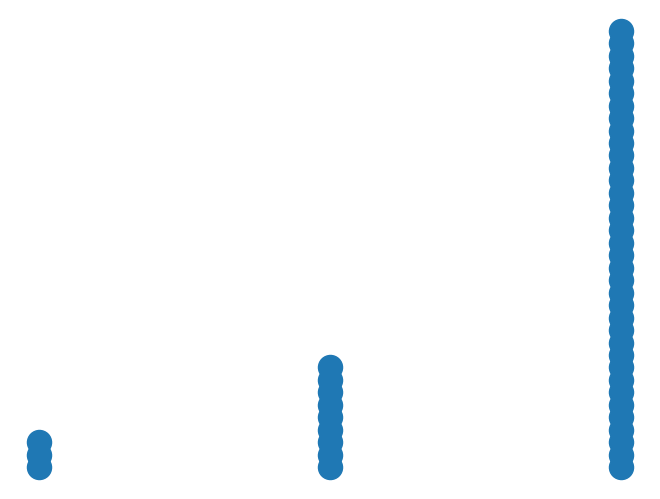

In [236]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

# create graph
G = nx.Graph()
for x in PORTS + HUBS + CITIES:
    G.add_node(x, bipartite= ['p-', 'h-', 'c-'].index(x[:2]))


nodes = G.nodes()
# for each of the parts create a set 
nodes_0  = set([n for n in nodes if  G.nodes[n]['bipartite']==0])
nodes_1  = set([n for n in nodes if  G.nodes[n]['bipartite']==1])
nodes_2  = set([n for n in nodes if  G.nodes[n]['bipartite']==2])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1
# draw graph
nx.draw(G, pos=pos)

In [237]:
def generate_matrices(alpha):
    # generates the matrices for each of the weights
    matrices = [] # list of matrixs for each weight class
    for weight in range(10):
        df_cities_weight = df_norm.iloc[weight::10,:]
        cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i], alpha) for i in range(len(df_cities_weight))]
        df_cities_weight['cost'] = cost
        df_cities_weight = df_cities_weight.drop(columns=['co2_per_unit', 'cost_per_unit', 'city_from_coord', 'city_to_coord', 'weight_class', 'distance'])
        declare_costs_graph(G, PORTS, HUBS, CITIES, df_cities_weight)
        M = get_min_cost_matrix(G, PORTS, CITIES, df_cities_weight)
        matrices.append(M)
    return matrices

In [238]:
def get_freq_matrix(df_func):
    # Matrix that stores the frequency of  path: [weight][port][customer]
    F = np.zeros((10, len(PORTS), len(CITIES)))
    for w in range(10):
        for p in range(len(PORTS)):
            for c in range(len(CITIES)):
                F[w, p, c] = np.sum(df_func.loc[(df_func['weight_class']==w) & (df_func['origin_port']==PORTS[p][2:]) & (df_func['customer']==CITIES[c][2:])]['units'].values)
    return F

In [239]:
df_orders = pd.read_csv('data\dataframefinal.csv')
F = get_freq_matrix(df_orders)

In [240]:
# we ponderate the vector with the calclated frequencies
def ponderate_vector(matrices, F, alpha):
    pond_vect = []
    for extra_h in range(len(CITIES)+1):
        sum = 0
        for w in range(10):
            for p in range(len(PORTS)):
                for c in range(len(CITIES)):
                    sum += F[w, p, c]*matrices[w][p, c, extra_h]
        if not CITIES[extra_h-1][2:] in [h[2:] for h in HUBS]:
            pond_vect.append((alpha, sum, CITIES[extra_h-1][2:] if extra_h > 0 else 'AAAA None'))
    return pond_vect

In [241]:
def sort_and_save(pond_vect, alpha):
    pond_vect.sort()
    df = pd.DataFrame(pond_vect, columns=['alpha', 'cost', 'extra_hub'])
    existing_df = pd.read_csv('data/results_alpha.csv')
    if not alpha in existing_df['alpha'].unique():
        df.to_csv('data/results_alpha.csv', mode='a', index=False, header=False)

In [242]:
def show_pond_vector(pond_vect):
    # histogram of pond_vect
    plt.bar([x[2] for x in pond_vect], [x[1] for x in pond_vect])
    plt.xticks(rotation=90)
    offset = 500
    plt.ylim(pond_vect[0][1] - offset, pond_vect[-1][1] + offset)
    plt.show()

In [243]:
def generate_hub_list(alpha, show = False):
    matrices = generate_matrices(alpha)
    pond_vect = ponderate_vector(matrices, F, alpha)
    sort_and_save(pond_vect, alpha)
    if show:
        show_pond_vector(pond_vect)

In [244]:
def better_extra_hub(alpha, port = False):
    '''returns the better extra hub for a given alpha'''
    df = pd.read_csv('data/results_alpha.csv')
    df = df.loc[df['alpha']==alpha]
    for i, x in df.iterrows():
        if port:
            return x['extra_hub']
        else:
            if not x['extra_hub'] in [p[2:] for p in PORTS]:
                return x['extra_hub']

In [ ]:
for alpha in range(0, 10):
    generate_hub_list(alpha/10)
    print('With alpha', alpha/10, 'better extra hub city:',better_extra_hub(alpha/10))

In [275]:
calculated_df = pd.read_csv('data/results_alpha.csv')
# para Amsterdam (alpha = 0, main objective is reduce cost)
normalized_cost = calculated_df.loc[(calculated_df['alpha']==0) & (calculated_df['extra_hub']=='Amsterdam')]['cost'].values[0]
original_cost = normalized_cost*(df_cities['cost_per_unit'].max() - df_cities['cost_per_unit'].min()) + df_cities['cost_per_unit'].min()
print(f"COST with Amsterdam hub: {original_cost:_.1f}")

# para Marseille (alpha = 1, main objective is reduce co2)
normalized_cost = calculated_df.loc[(calculated_df['alpha']==1) & (calculated_df['extra_hub']=='Marseille')]['cost'].values[0]
original_cost = normalized_cost*(df_cities['co2_per_unit'].max() - df_cities['co2_per_unit'].min()) + df_cities['co2_per_unit'].min()
print(f"co2 EMISSION with Marseille hub {original_cost:_.1f}")

COST with Amsterdam hub: 327_413_735.4
co2 EMISSION with Marseille hub 566_732_476.3


In [247]:
best = better_extra_hub(1)
print(best)

Marseille
